# Build a simple Classifier with PyTorch

We build a feed-forward neural network that classify whether a point (x_1,x_2) belongs to one of two circles. 

## Make some toy data

For sampling points belonging to two circles we use scikit-learn: https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html

In [1]:
#!pip install scikit-learn matplotlib pandas torch torchvision

In [2]:
from sklearn.datasets import make_circles #produces points belonging to two circles 

# X data points
# y labels
X, y = make_circles(1000,             # number of sample points
                    noise=0.03,       # add some noise to the points
                    random_state=42)  # keep random state so we get the same values


In [3]:
# Make DataFrame of circle data
import pandas as pd

tabular_data = {"X1": X[:, 0], "X2": X[:, 1], "label": y}

circles = pd.DataFrame(tabular_data)
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

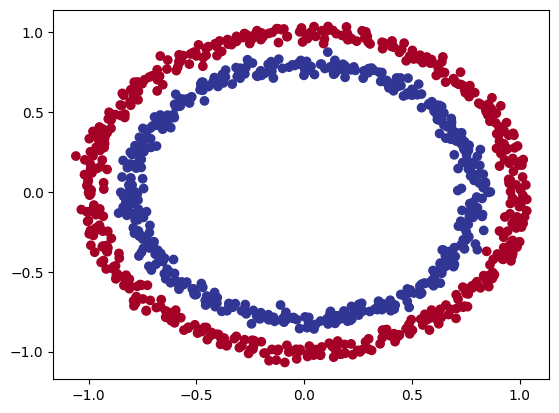

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## Define the Neural Network with PyTorch

In [6]:
import torch
import torch.nn as nn

### 1. Turn Data into PyTorch Tensors

In [7]:
X = torch.from_numpy(X).type(torch.float32) #X.dtype
y = torch.from_numpy(y).type(torch.float32) #y.dtype

In [8]:
X.size()

torch.Size([1000, 2])

### 2. Split Data into train and test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,   # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 3. Activate GPU if available

In [10]:
torch.backends.mps.is_available()

True

In [11]:
# Make device agnostic code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")    # set to cuda if GPU is available
if torch.backends.mps.is_available():                      # mps device enables high-performance training on GPU for MacOS devices with Metal programming framework
                                                           # https://pytorch.org/docs/stable/notes/mps.html
    device = torch.device("mps")
device

device(type='mps')

### 4. Define a Model in 3 steps

- Construct a model class that subclasses nn.Module
- Create layers with nn.Linear capable of handling X and y input and output shapes and activation function
- Define a forward method containing the forward pass computation
- Create an instance of the model and send it to target device

In [12]:
class CircleModel(nn.Module): # Construct a model class that subclasses nn.Module
    def __init__(self):
        super().__init__()
        # 2. Create layers with nn.Linear capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
        #self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        #self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
        
        self.relu = nn.ReLU() # <- add in ReLU activation function
        
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        #u_1 = self.layer_1(x)
        #z_1 = self.relu(u_1)
        #u_2 = self.layer_2(z_1)
        #return u_2
        #return self.layer_2(self.relu(self.layer_1(x))) 
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
 

# 4. Create an instance of the model and send it to target device
model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### 5. Setup Loss and Optimizer

As loss function we use the BCEWithLogitsLoss for Binary Classification. This loss combines a Sigmoid layer and the BCELoss in one single class. 


$$ L = y * log(sig(x)) + (1−y)⋅log(1−sig(x)) $$

<div id='svgWrapper'>
    <img src='./media/Sigmoid-function.svg'/>
</div>


see https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

The Sigmoid function maps the "logits" (values from last layer) into a probability!

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### 6. Run the Traing Loop and fit the model to the data

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc
    

torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()

    # needed for accuracy calculation
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels (round function)
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using just the logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.51751, Accuracy: 94.88% | Test Loss: 0.55446, Test Accuracy: 92.00%
Epoch: 100 | Loss: 0.42027, Accuracy: 95.88% | Test Loss: 0.46670, Test Accuracy: 92.50%
Epoch: 200 | Loss: 0.30908, Accuracy: 98.50% | Test Loss: 0.35373, Test Accuracy: 97.00%
Epoch: 300 | Loss: 0.21629, Accuracy: 99.12% | Test Loss: 0.25764, Test Accuracy: 98.50%
Epoch: 400 | Loss: 0.15117, Accuracy: 99.38% | Test Loss: 0.19461, Test Accuracy: 98.50%
Epoch: 500 | Loss: 0.10487, Accuracy: 99.75% | Test Loss: 0.14666, Test Accuracy: 99.00%
Epoch: 600 | Loss: 0.07757, Accuracy: 99.75% | Test Loss: 0.11404, Test Accuracy: 99.00%
Epoch: 700 | Loss: 0.06093, Accuracy: 99.88% | Test Loss: 0.09314, Test Accuracy: 99.00%
Epoch: 800 | Loss: 0.04935, Accuracy: 99.88% | Test Loss: 0.07847, Test Accuracy: 99.00%
Epoch: 900 | Loss: 0.04140, Accuracy: 99.88% | Test Loss: 0.06888, Test Accuracy: 99.00%


In [16]:
############## helper fun ction from 
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

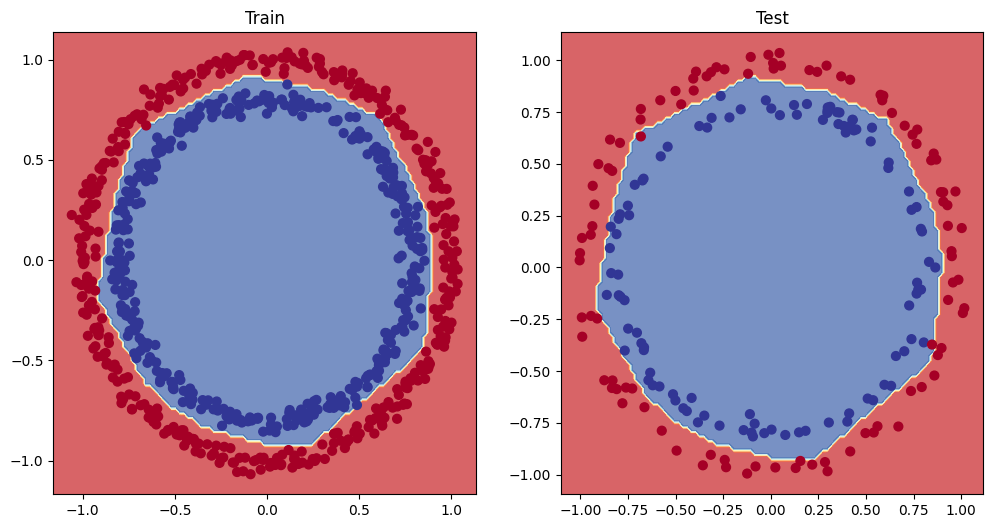

In [17]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)